In [2]:
import numpy as np
import pandas as pd 

# Visualisation
import matplotlib.pyplot as plt

from datetime import datetime

# Scaling
from sklearn.preprocessing import MinMaxScaler

# Deep Learning using Keras
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, TensorBoard

# Model insights
import tensorboard

# Clear any logs from previous runs
!rm -rf ./logs/

## Loading data from CSV file to DataFrame

In [3]:
df=pd.read_csv('/content/NSE-Tata-Global-Beverages-Limited.csv',date_parser=True)

In [4]:
df.shape

(1235, 8)

In [5]:
df.head()

,Date,Open,High,Low,Last,Close,Total Trade Quantity,Turnover (Lacs)
0,2018-10-08,208.00,222.25,206.85,216.00,215.15,4642146.0,10062.83
1,2018-10-05,217.00,218.60,205.90,210.25,209.20,3519515.0,7407.06
2,2018-10-04,223.50,227.80,216.15,217.25,218.20,1728786.0,3815.79
3,2018-10-03,230.00,237.50,225.75,226.45,227.60,1708590.0,3960.27
4,2018-10-01,234.55,234.60,221.05,230.30,230.90,1534749.0,3486.05


In [6]:
df.tail()

,Date,Open,High,Low,Last,Close,Total Trade Quantity,Turnover (Lacs)
1230,2013-10-14,160.85,161.45,157.70,159.3,159.45,1281419.0,2039.09
1231,2013-10-11,161.15,163.45,159.00,159.8,160.05,1880046.0,3030.76
1232,2013-10-10,156.00,160.80,155.85,160.3,160.15,3124853.0,4978.80
1233,2013-10-09,155.70,158.20,154.15,155.3,155.55,2049580.0,3204.49
1234,2013-10-08,157.00,157.80,155.20,155.8,155.80,1720413.0,2688.94


## Splitting data into Train and Test
As this is a sequential dataset we are splitting by date and not randomly

In [7]:
train=df[df['Date']<'2017-01-01']
test=df[df['Date']>='2017-01-01']

## Storing only required columns

In [9]:
cols=['Open','High','Low','Close','Total Trade Quantity']
train=train[cols]
test=test[cols]

## Scaling the data using Min-Max Scaler

In [10]:
scaler=MinMaxScaler()

nTrain=scaler.fit_transform(train)
nTrain

array([[0.24709898, 0.25775327, 0.28864569, 0.26800554, 0.0540708 ],
       [0.22662116, 0.24190214, 0.26812585, 0.25554017, 0.05454569],
       [0.22116041, 0.2398346 , 0.2626539 , 0.23476454, 0.04519652],
       ...,
       [0.72354949, 0.77463818, 0.76402189, 0.79639889, 0.17829759],
       [0.71945392, 0.73880083, 0.74076607, 0.73268698, 0.1149127 ],
       [0.73720137, 0.73328739, 0.75512996, 0.73614958, 0.09550905]])

## Storing data in a Numpy array

In [38]:
xTrain=[]
yTrain=[]
window=60

for i in range(window,nTrain.shape[0]):
    xTrain.append(nTrain[i-window:i])
    yTrain.append(nTrain[i,0])

xTrain,yTrain=np.array(xTrain),np.array(yTrain)

xTrain.shape,yTrain.shape

((737, 60, 5), (737,))

## Model Definition

In [12]:
model=Sequential()

model.add(LSTM(units=50, activation='tanh', return_sequences=True,recurrent_activation = "sigmoid", input_shape=(window,5)))
model.add(Dropout(0.2))

model.add(LSTM(units=60, activation='tanh', return_sequences=True, recurrent_activation = "sigmoid"))
model.add(Dropout(0.3))

model.add(LSTM(units=80, activation='tanh', return_sequences=True, recurrent_activation = "sigmoid"))
model.add(Dropout(0.4))

model.add(LSTM(units=120, activation='tanh', recurrent_activation = "sigmoid"))
model.add(Dropout(0.5))

model.add(Dense(units=1))

In [13]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 60, 50)            11200     
_________________________________________________________________
dropout (Dropout)            (None, 60, 50)            0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 60, 60)            26640     
_________________________________________________________________
dropout_1 (Dropout)          (None, 60, 60)            0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 60, 80)            45120     
_________________________________________________________________
dropout_2 (Dropout)          (None, 60, 80)            0         
_________________________________________________________________
lstm_3 (LSTM)                (None, 120)               9

In [14]:
# Checkpoint to store weights for least obtained loss 
checkpoint = ModelCheckpoint('best.h5', monitor='loss', verbose=1,save_best_only=True, save_freq="epoch")

# Define the Keras TensorBoard callback.
logdir="logs/fit/" + datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = TensorBoard(log_dir=logdir)

# Optimizer: Adam lr=0.001
# Loss Function: Mean Squared Error
model.compile(optimizer=Adam(), loss='mean_squared_error')

## Model Training

In [15]:
History = model.fit(xTrain,yTrain,epochs=100,callbacks=[checkpoint,tensorboard_callback])

Epoch 1/100
 1/24 [>.............................] - ETA: 0s - loss: 0.3563WARNING:tensorflow:From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/summary_ops_v2.py:1277: stop (from tensorflow.python.eager.profiler) is deprecated and will be removed after 2020-07-01.
Instructions for updating:
use `tf.profiler.experimental.stop` instead.
24/24 [==============================] - ETA: 0s - loss: 0.0523
Epoch 00001: loss improved from inf to 0.05225, saving model to best.h5
24/24 [==============================] - 4s 168ms/step - loss: 0.0523
Epoch 2/100
24/24 [==============================] - ETA: 0s - loss: 0.0173
Epoch 00002: loss improved from 0.05225 to 0.01733, saving model to best.h5
24/24 [==============================] - 4s 157ms/step - loss: 0.0173
Epoch 3/100
24/24 [==============================] - ETA: 0s - loss: 0.0157
Epoch 00003: loss improved from 0.01733 to 0.01574, saving model to best.h5
24/24 [==============================] - 4s 159ms/step - loss: 0.01

## Loss function vs Epochs

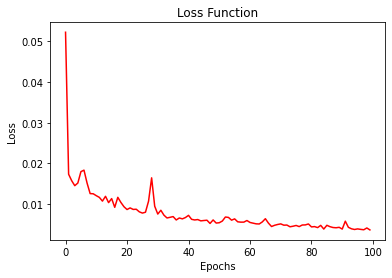

In [19]:
plt.plot(History.history['loss'],color="r",label="Training Accuracy")
plt.ylabel("Loss")
plt.xlabel("Epochs")
plt.title("Loss Function")
plt.show()

## Restoring the best weights

In [20]:
model = load_model('best.h5')

In [21]:
last_window=train.tail(window)
testSet=last_window.append(test,ignore_index=True)
nTest=scaler.transform(testSet)

In [22]:
xTest=[]
yTest=[]

for i in range(window,nTest.shape[0]):
    xTest.append(nTest[i-window:i])
    yTest.append(nTest[i,0])

xTest,yTest=np.array(xTest),np.array(yTest)
xTest.shape,yTest.shape

((438, 60, 5), (438,))

In [23]:
yPred=model.predict(xTest)

In [24]:
yPred

array([[0.7049475 ],
       [1.2074841 ],
       [1.2831047 ],
       [1.2262119 ],
       [1.2999802 ],
       [1.2700044 ],
       [1.2833912 ],
       [1.2679203 ],
       [1.3357068 ],
       [1.2554067 ],
       [1.2859107 ],
       [1.265083  ],
       [1.3203102 ],
       [1.2925652 ],
       [1.2615007 ],
       [1.2032497 ],
       [1.1691711 ],
       [1.2499288 ],
       [1.2510233 ],
       [1.2305521 ],
       [1.2360046 ],
       [1.2158045 ],
       [1.3506187 ],
       [1.2946182 ],
       [1.2804083 ],
       [1.2831668 ],
       [1.2910769 ],
       [1.3021222 ],
       [1.2792524 ],
       [1.2923867 ],
       [1.3332309 ],
       [1.3451799 ],
       [1.3216116 ],
       [1.2871135 ],
       [1.2885576 ],
       [1.2920219 ],
       [1.2776997 ],
       [1.3095676 ],
       [1.3111547 ],
       [1.2976199 ],
       [1.3193849 ],
       [1.2747031 ],
       [1.2868737 ],
       [1.2564266 ],
       [1.3488659 ],
       [1.3328549 ],
       [1.3140631 ],
       [1.303

In [25]:
scaler.scale_,scaler.data_min_

(array([1.36518771e-02, 1.37835975e-02, 1.36798906e-02, 1.38504155e-02,
        5.89477253e-08]),
 array([1.0300e+02, 1.0460e+02, 1.0000e+02, 1.0265e+02, 1.0018e+05]))

In [27]:
scaleVal=1/2.97428729e-04

## Inverse Scaling and Normalisation

In [28]:
yPred=(yPred*scaleVal)+testSet['Open'].min()
yTest=(yTest*scaleVal)+testSet['Open'].min()

In [29]:
yPred = (yPred*yTest.sum())/(yPred.sum())

## Plotting predicted values

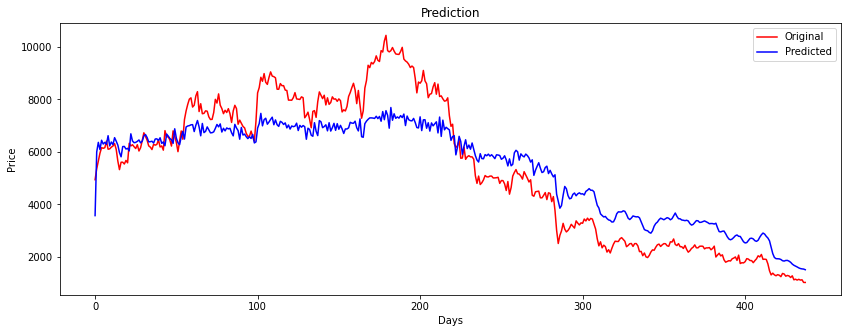

In [30]:
plt.figure(figsize=(14,5))
plt.plot(yTest,color='red',label='Original')
plt.plot(yPred,color='blue',label='Predicted')

plt.title('Prediction')
plt.xlabel('Days')
plt.ylabel('Price')

plt.legend()
plt.show()


In [37]:
from sklearn.metrics import r2_score
r2_score(yTest, yPred)

0.8317683154378149